<h2 align="center">Summary Report for</h2>
<h1 align="center">Multi-Physics Multi-Scale Computational Modeling, LLC</h1>
<h2 align="center">Bill Spotz</h2>
<h2 align="center">Sandia National Laboratories</h2>
<h2 align="center">December 19, 2018</h2>

**Statement of Work:**  SNL will provide, as time and budget allows, consultation developing a code that takes as input a description of a partial differential equation (e.g. in LaTeX syntax) and that generates as output a C++ class that is a viable Albany evaluator that computes the finite element residual of the provided equation. SNL will also provide consultation to demonstrate this capability to solve a simple model problem. A summary report will be written.

# Introduction

To complete the Statement of Work (SOW), a set of tools was chosen that are appropriate to the task: The Jupyter Notebook running Python 3, using sympy:

   *  **Jupyter Notebook** The goal is for users to start with a representation of a partial differential equation (PDE), and generate code that is a finite element representtion of that PDE.  As such, we want a tool that provides an interface to code but that also renders beautiful mathematics.  The Jupyter Notebook fills these requirements and much more.  Note that this summary report is generated using Jupyter Notebook.

   *  **Python 3** Jupyter Notebooks support many languages, but Python was the first.  Python syntax is clean and easy for users to pick up, the collection of built-in and third-party libraries is extensive, and the scientific Python community is sizeable, broad and vibrant.

   *  **SymPy** *Sym*bolic *Py*thon is a third-party symbolic manipulation module for Python that provides the capability of manipulating PDEs in the manner prescribed by the SOW.  Specifically, it supports mathematic manipulation of derivatives, integrals, summations and a host of other mathematical objects.  It can convert LaTeX representations of mathematics into its own tree-based representation of mathematical expressions and equations, and it can convert its representation of expressions into code, valid for many different programming  languages.

**A note about this Summary Report:** This report was developed within a Jupyter Notebook, which means that the code presented in the report is "live" when viewed using Jupyter Notebook.  Cell blocks preceeded by `In [#]: ` where `#` is a number, are actual code, and cell blocks preceeded by `Out[#]: ` are the actual output produced by the code block with the same number.  Changing the input code will change the resulting output.  For reporting purposes, this notebook will be converted to other formats -- HTML and PDF -- which will be static documents, but whose output cells will be authentic.  Using a notebook also demonstrates the professional typesetting of mathematical expressions that will be a part of the end users interface experience.

# A Note on Using LaTeX as Input

The `sympy` module supports an incredible range of mathematical syntax, and the Python interface for constructing PDEs quickly became quite easy to use for the purposes of this project.  However, the first task in the SOW is to provide "consultation developing a code that takes as input a description of a partial differential equation (e.g. in LaTeX syntax) ...".  This project certainly demonstrates capabilities that "[take] as input a description of a partial differential equation," but that description is `sympy` syntax, not LaTeX, as suggested in the SOW.

A converter from LaTeX to `sympy` syntax is all that is needed to remedy this situation, and indeed, such converters already exist.  For example, __[latex2sympy](https://github.com/augustt198/latex2sympy)__ is one such converter.  Unfortunately, it does not have a `conda` installer, making it less convenient than the other tools used in this project.  Also, I have not tested it extensively enough to determine whether it is completely suitable for our purposes.  Since it is open source, both adding a `conda` installer and making contributions that might address any shortcomings are within the realm of possibility.

# The `sympy` Module

In this report, I will demonstrate how to start with the description of a PDE using `sympy` syntax, apply the various steps of approximating it using the finite element method, and ultimately use that symbolic representation of an approximation to generate code usable in an application code such as Albany.  We begin by importing functions and classes we will need from the Python module `sympy`.  Calling the `init_printing()` function will give us nicely formatted output mathematics within this notebook.

In [1]:
from sympy import init_printing, Symbol, Function, Eq, Derivative
init_printing()

# The `regen` Module

The `regen` module is the Python module being developed under this project, whose goal is to start with a practical expression of a PDE (using `sympy` syntax, as we do here) and from that, perform the various steps of applying the finite element method, such as converting to the weak form, applying the Galerkin approximation, and evaluating integrals using Gaussian quadrature.

In [2]:
import regen

# Defining a Model Problem

The model problem we will be using for demonstration purposes comes from *Finite Elements: An Introduction, Volume I* by Eric B. Becker, Graham F. Carey, and J. Tinsley Oden.  In chapter 1 of that textbook, the authors develop a finite element method in the context of a model problem

$$
\begin{array}{ccc}
    -u'' + u = x, & 0 < x < 1 \\
    u(0) = 0,     & u(1) = 0
\end{array}
$$

where $u$ is our solution variable and the prime symbol $'$ indicates differention with respect to $x$.

To define our equation using `sympy`, we need to define `x` as a `Symbol` and `u` as a `Function` of `x`, then use the `Eq` and `Derivative` classes to define the equation:

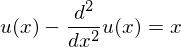

In [3]:
x = Symbol("x")
y = Symbol("y")
u = Function("u")(x)
model_prob = Eq(-Derivative(u,x,2) + u, x)
model_prob

# Weak Form

Our first goal is to obtain the weak form of our model problem.  The weak form is obtained by multiplying the PDE by a test function and integrating the result over the domain.  Typically, integration by parts is applied to reduce terms with second derivatives to first derivatives.  This reduces the smoothness requirements on both the test functions and  the basis functions that ultimately approximate the solution.

The `regen.weak_form()` function takes an `Eq` object as its first argument, the test function as its second argument (so that the user can prevent naming conflicts), and which we name `v`. Note that through inspection, the `regen.weak_form()` function detects the solution variables, in this case `(u(x),)` and the domain variable `x`.

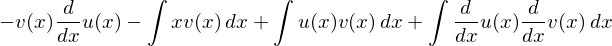

In [4]:
v = Function("v")(x)
weak_form = regen.weak_form(model_prob, v)
weak_form

The weak form is returned in the form of a `sympy.Expr` rather than a `sympy.Eq`, with the implication that the expression sums to zero.  Notice that the term involving the second derivative of $u$ has been replaced by two terms that involve the first derivatives of $u$ and $v$.

# Galerkin Approximation

We now want to substitute an approximation for $u$ into our model problem.  Specifically, we are going to change the model problem from solving for $u_h$ instead of $u$, where

$$
u_h(x) = \sum_{i=0}^{N-1} u_i \phi_i(x)
$$

and the test functions are given by

$$
v(x) \in \{\phi_j(x)\} \, \mbox{ for } j = 0 \ldots N-1
$$

and the ${\phi_i(x)}$ are our basis functions of dimension $N$.  Note that `sympy` supports `IndexedBase` objects and `Function` objects, but not `Function`s that are indexed (at least not that I have figured out yet).  My workaround for this is to define `phi` as a `Function`, with two arguments, `i` (or `j`) and `x`.  This results in the mathematical notation $\phi(i,x)$ rather than the more traditional $\phi_i(x)$.

The `regen.galerkin()` function takes as its first argument an expression or a sequence of expressions, in this case our `weak_form` expression.  For the second argument, it needs to know the test function we used to obtain the weak form, because this function does not get expanded as a series.  The third argument is the basis function for the Galerkin approximation.  It should be constructed without arguments, neither index nor domain variable, because the `regen.galerkin()` function will add these.

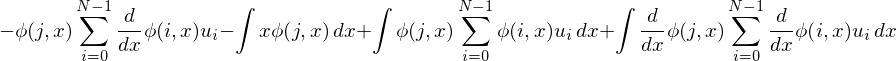

In [5]:
phi = Function('phi')
galerkin = regen.galerkin(weak_form, v, phi)
galerkin

# Quadrature

The $\phi(i,x)$ in the expression above are basis functions that can, in theory, take any form we wish.  In practice, we typically define piecewise polynomial basis functions, which means that the expression above has an analytic solution.  However, it is typically more efficient to "approximate" the above integrals using Gaussian quadrature, followed by choosing the number of quadrature points to represent the integral exactly.

As such, we now wish to convert the integrals to summations by applying Gaussian quadrature, which can be done by the `regen.quadrature()` function:

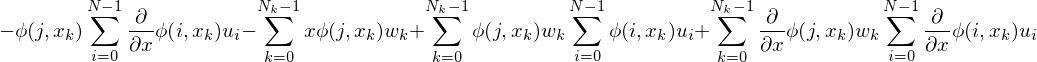

In [6]:
quadrature = regen.quadrature(galerkin)
quadrature

At a glance, you can see that this expression contains summations, but no integrals, unlike the previous expression, which contained both.

# The Substitution Bug

At this point in the process, I discovered what I believe is a bug in `sympy`.  The goal at this point is to massage the above expression into one that is more conducive to code generation.  The problem is the derivatives of the basis functions, e.g.

$$
\frac{\partial}{\partial x} \phi(i,x)
$$

evaluated at discrete points $x = x_k$.  Our code will simply store an array with these values, so we want to replace these derivatives with a simple function that represents these derivatives, say

$$
\phi_x(i, x_k)
$$

This is the purpose of the `regen.substitute_derivatives()` function, but it does not work as expected:

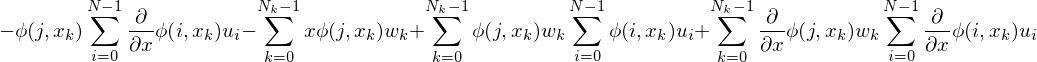

In [7]:
regen.substitute_derivatives(quadrature)

The above expression should have regular functions substituted for the derivatives, but does not.  I demonstrate this bug, in a simpler context, in __[this notebook](http://localhost:8888/notebooks/Substitution%20Bug.ipynb)__, noting that the desired substitution works in a simpler context, but not within a summation.  I have submitted this bug as a question to Stack Overflow, and barring a response with a reasonable workaround, I will submit it as a bug to the SymPy developers.

Given the extremely short duration of this project, I accepted this bug as an issue that would not be fixed by the project end date, and pushed ahead to further assess the project's goals.  As a temporary workaround for this problem, I will `print(quadrature)`, cut-and-paste, and then modify the expression to be what we need it to be.

In [8]:
print(quadrature)

-phi(j, x[k])*Sum(Derivative(phi(i, x[k]), x)*u[i], (i, 0, N - 1)) - Sum(x*phi(j, x[k])*w[k], (k, 0, N_k - 1)) + Sum(phi(j, x[k])*w[k]*Sum(phi(i, x[k])*u[i], (i, 0, N - 1)), (k, 0, N_k - 1)) + Sum(Derivative(phi(j, x[k]), x)*w[k]*Sum(Derivative(phi(i, x[k]), x)*u[i], (i, 0, N - 1)), (k, 0, N_k - 1))


In [9]:
from sympy import Idx, IndexedBase, Sum, Symbol, Integral
N     = Symbol('N', integer=True)
N_k   = Symbol('N_k', integer=True)
i     = Idx('i', (0,N-1))
j     = Idx('j', (0,N-1))
k     = Idx('k', (0,N_k-1))
ui    = IndexedBase('u')
xk    = IndexedBase('x')
w     = IndexedBase('w')
phi_x = Function('phi_x')

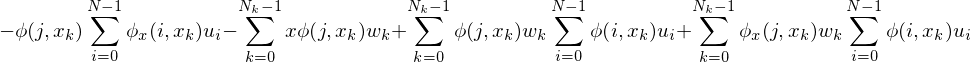

In [10]:
discrete = -phi(j, xk[k])*Sum(phi_x(i, xk[k])*ui[i], (i, 0, N - 1)) - \
Sum(x*phi(j, xk[k])*w[k], (k, 0, N_k - 1)) + \
Sum(phi(j, xk[k])*w[k]*Sum(phi(i, xk[k])*ui[i], (i, 0, N - 1)), (k, 0, N_k - 1)) + \
Sum(phi_x(j, xk[k])*w[k]*Sum(phi(i, xk[k])*ui[i], (i, 0, N - 1)), (k, 0, N_k - 1))
discrete

# Code Generation

To be added.

# Conclusions

Based on the experience obtained under this NMSBA project, I can draw the following conclusions:

* The Jupyter Notebook should provide an extremely useful interface for users who would want to use the tools ultimately developed in the aftermath of this project to generate Albany `ModelEvaluators`.  It will allow these users to express their PDEs of interest, check them visually with professionally-rendered mathematics, and submit them to the series of manipulations supported by the `regen` module to ultimately generate code for use in Albany.

* The `sympy` module provides the tools to successfully formulate the weak form of the PDE, apply a Galerkin approximation, and utilize Gaussian quadrature to generate an expression that is nearly ready to be used as input to the `sympy` code generation algorithms.  There is one barrier, though: the __[substitution bug](http://localhost:8888/notebooks/Substitution%20Bug.ipynb)__.  This bug must be fixed before a fully automated system to achieve the project's goals can be achieved.

* The model problem employed here is 1D, but most problems of interest will have two, three or four dimensions -- $(x,y,z,t)$ for example.  The `sympy` module certainly supports multivariate vector PDEs, via the `CoordSys3D` sub-module:

In [11]:
from sympy.vector import CoordSys3D, Del
R = CoordSys3D("R")
delop = Del()
gradient_field = delop(R.x*R.y*R.z)
gradient_field.doit()

*  This means that the type of problems of interest from science and engineering can be represented.  The functions in the `regen` module that would need modification to support higher dimensions include:

    - `weak_form(eqs, test_func)` would need to be updated to work for higher dimensions.  It currently assumes 1D integrals

    -  `integrate_by_parts(u,v,x)` currently assumes 1D, as implied by the `x` integration argument, meaning the argument list would also change
    
    - `galerkin(expr, test_func, basis)` currently assumes 1D basis functions, which should be expanded to multidimensional tensor-product basis functions

    - `quadrature(expr)` assumes 1D integrals
    
    - `substitute_derivatives(expr)` assumes 1D derivatives

*  I did not consider boundary conditions (BCs) here, but of course BCs are extremely important for any type of solution (analytic or approximate) for PDEs.  On the other hand, Albany already supports certain types of BCs, and the idea would be to leverage those within the developed application code whenever available.  The `sympy` module supports both definite and indefinite integrals (BCs are expressed through the bounds of definite integrals), so representation is not an issue.  Ultimately I felt that the most efficient use of limited time was to focus on the governing equations.

*  The demonstration here was for a single PDE, but sets of PDEs are supported as well.  Typically, the first argument to functions in the `regen` module is a `sympy.Eq` or `sympy.Expr` object or a sequence of these objects.  These functions typically return a single `sympy.Expr` object or a tuple of them, depending on the input.  Internally, the `regen` module inspects these expressions to obtain sets of objects for the expression(s) such as differentiated functions, differentiating variables, and domain variables.  These inspections can obviously differ for a single PDE versus a set of PDEs, and processing sets of PDEs was taken as a requirement.

*  An object-oriented interface would be warranted and easy to implement.  Specifically, `regen` could contain a class definition named, say, `PDE`, whose constructor would take a single PDE or a set of PDEs.  It could possibly perform conversion from LaTeX to `sympy` if needed.  It could have optional arguments providing the test functions and basis functions.  During the construction phase, the class could obtain the weak form, the Galerkin approximation, and the discrete representation.  These expressions could be stored as attributes of the object, as could the results of the inspection of the (set of) PDE(s).  The class could also provide a method or methods for code generation, which would allow for supporting multiple output languages.